# DOMAIN ADAPTATION WITH MEMO

P.S. Please change the root to Imagenet-A folder under Notebook Configuration

Deep neural networks excel in computer vision tasks like image classification, object detection, and anomaly detection. However, they often suffer from performance drops due to domain shifts—situations where test images differ from training images. Addressing this challenge is crucial for real-world applications where such shifts are common and unpredictable.

Traditional domain adaptation techniques require access to training data or multiple samples, which can be impractical due to privacy and logistical issues. Test-Time Adaptation (TTA) offers a solution by improving model robustness during the testing phase, adapting to each test sample individually without needing additional training data.

This project focuses on developing and evaluating a TTA method for image classification, drawing inspiration from Marginal Entropy Minimization with One Test Point (MEMO). We implement MEMO with marginal entropy and CLIP as a backbone for zero-shot performance.

The evaluation of the TTA method will be conducted using the ImageNet-A dataset, which contains about 7,500 challenging images with significant domain shifts. Performance will be measured by top-1 accuracy on this dataset.

## SETUP

In [1]:
!pip install ftfy regex tqdm -q
!pip install git+https://github.com/openai/CLIP.git -q

import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler, autocast
import torchvision.transforms as transforms
from torchvision.transforms import RandAugment
from PIL import Image, ImageOps
import numpy as np

import matplotlib.pyplot as plt
import clip
import copy

import re
import pandas as pd
import random


from io import BytesIO
from pathlib import Path

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 46.1 MB/s eta 0:00:00


In [2]:
!pip install wandb
import wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.2/289.2 kB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.7 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Configure the Notebook:

Please configure the path before running the notebook

In [4]:
wandb_active = False
root_dir = "/content/drive/MyDrive/DL_Project/imagenet-a"

If you run with wandb uncomment the following line

In [5]:
# wandb.login()

In [6]:
if wandb_active:
  # wandb config
  WANDB_NOTEBOOK_NAME = "sagemaker"
  # Initialize WandB
  wandb.init(project="imagenet-adaptation-final")
  columns = ["Original Label", "Baseline Label", "Adapted Label", "Prediction Changed"]
  augmentation_table = wandb.Table(columns=columns)

## Load Dataset

- Please change root under notebook configuration to Imagenet-A folder

ImageNet-A is a challenging subset of the ImageNet dataset, containing around 7,500 images specifically selected for their difficulty. These images include unusual perspectives, occlusions, and background variations that standard models struggle to classify correctly.

Key Features
Composition: 7,500 images
Challenge: Images exhibit significant domain shifts, making them difficult for conventional models.
Diversity: Spans a wide range of categories, similar to the original ImageNet dataset.
Annotations: Maintains the same labeling standards as ImageNet.

In [7]:
class ImageNetADataset(Dataset):
    def __init__(self, root, transform=None):
        ''' get image paths and labels of dataset. '''
        self.root = root # define the root path
        self.transform = transform if transform else transforms.ToTensor() # define transformation of the image
        self.folder_names = [file for file in os.listdir(root) if file[0] == "n"] # get all folder names in the dataset
        self.class_names, self.folder_to_class_name = self.get_class_names() # get the class names from the README.txt
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.class_names)} # add mapping of the class names and indexes
        self.idx_to_class = {idx: cls_name for cls_name, idx in self.class_to_idx.items()}  # add reverse mapping

        # write all individual image path names and corresponding label (as index) to list
        self.image_paths, self.labels = [], []
        self.n_label = len(self.class_names)
        for class_name in self.folder_names: # for all folders
            class_dir = os.path.join(root, class_name)
            if os.path.isdir(class_dir): # make sure to only run for folders
                for img_name in os.listdir(class_dir):
                    self.image_paths.append(os.path.join(class_dir, img_name)) # append image path
                    self.labels.append(self.class_to_idx[self.folder_to_class_name[class_name]]) # append image label


    def __len__(self):
        ''' return number of images in dataset. '''
        return len(self.image_paths)

    def __getitem__(self, idx):
        ''' return image and label for idx. '''
        img_path = self.image_paths[idx]
        image = Image.open(img_path)
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

    def get_class_names(self):
        ''' extract class names and mapping for folder names from README.txt. '''

        # Load the ImageNet class ReadMe file containing label to folder key
        read_me_file = [file for file in os.listdir(self.root) if file[0] == "R"][0]
        read_me_dir = (f"{self.root}/{read_me_file}")
        try:
            with open(read_me_dir, "r", encoding="utf-8") as file:
                readme_txt = file.read()
        except UnicodeDecodeError: # wrong file
            print(f"UnicodeDecodeError cant open ReadMe file: {read_me_dir}")

        # Extraction of folder names and labels with regex pattern
        regex_pattern = r"n\d{5}.+\n"
        matches = re.findall(regex_pattern, readme_txt)

        folder_to_class_name = {match[:9]: match[10:-2] for match in matches} # save mapping in dict
        class_names = [match[10:-2] for match in matches] # save class names in list

        return class_names, folder_to_class_name

### Dataset Class Test

Dataset length: 7500
Printing some file names and their corresponding labels:
File: /content/drive/MyDrive/DL_Project/imagenet-a/n01986214/0.008244_scorpion _ scorpion_0.97206724.jpg, Label: hermit crab
File: /content/drive/MyDrive/DL_Project/imagenet-a/n01986214/0.000825_tarantula _ tarantula_0.9921301.jpg, Label: hermit crab
File: /content/drive/MyDrive/DL_Project/imagenet-a/n01986214/0.012881_crayfish _ crayfish_0.99349034.jpg, Label: hermit crab
File: /content/drive/MyDrive/DL_Project/imagenet-a/n01986214/0.093460_crayfish _ crayfish_0.6130887.jpg, Label: hermit crab
File: /content/drive/MyDrive/DL_Project/imagenet-a/n01986214/0.000610_crayfish _ crayfish_0.9998024.jpg, Label: hermit crab


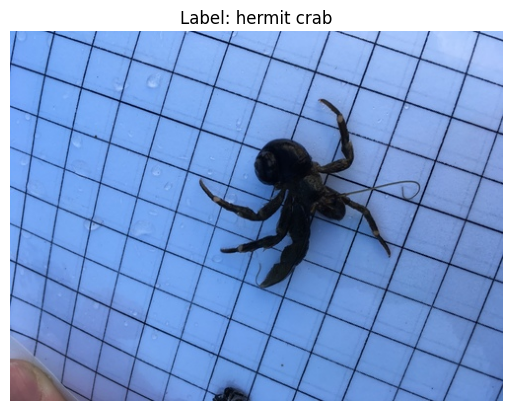

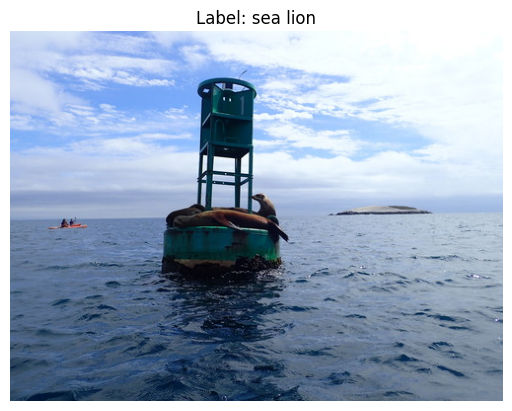

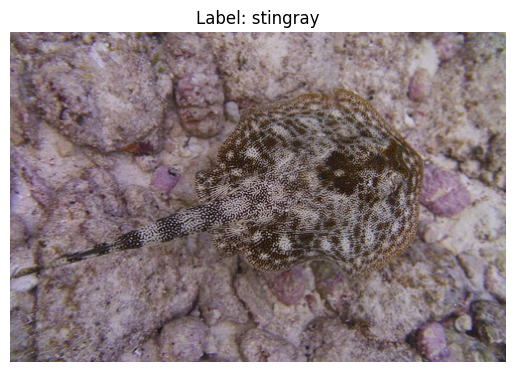

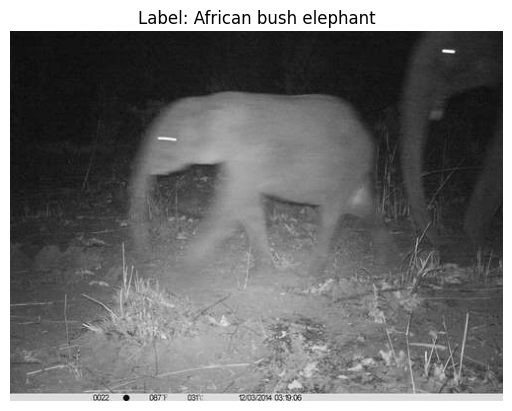

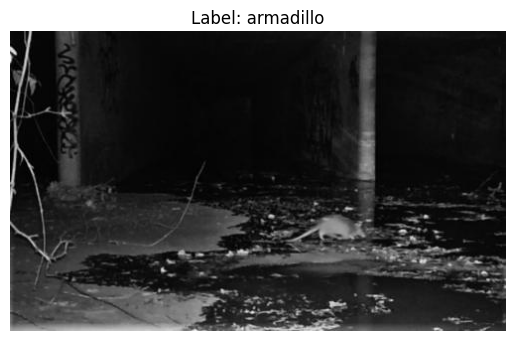

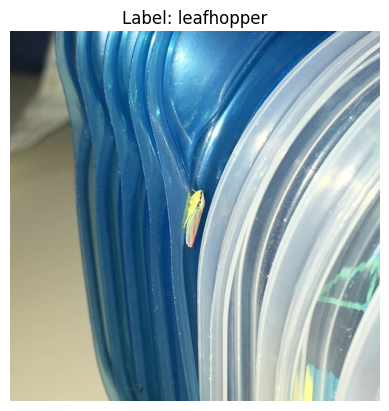

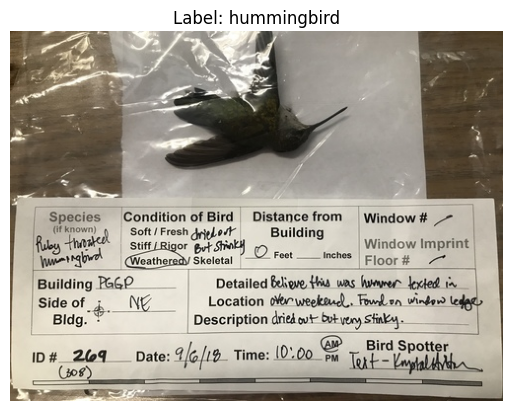

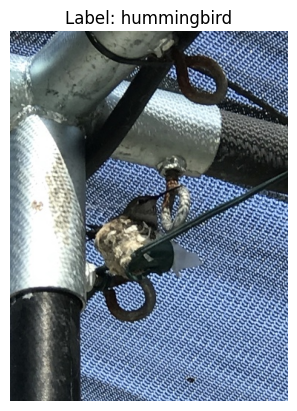

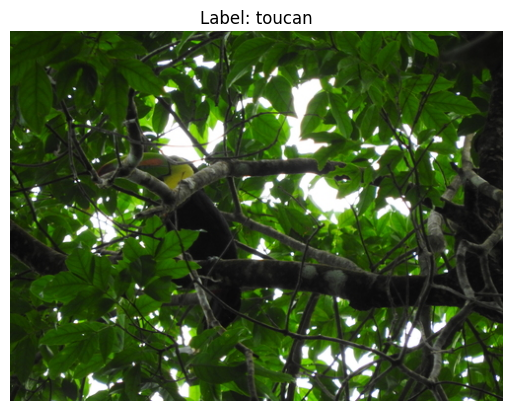

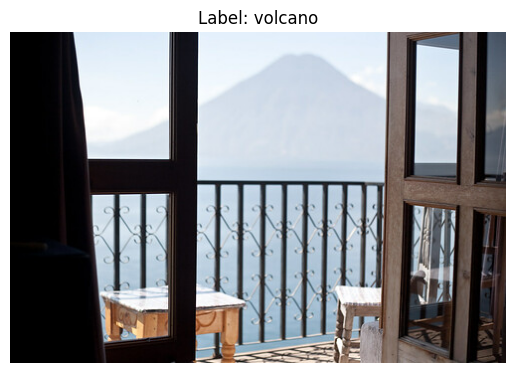

In [8]:
def test_imagenet_a_dataset(root_dir= "/content/drive/MyDrive/DL_Project/imagenet-a"):
    dataset = ImageNetADataset(root=root_dir)
    print(f"Dataset length: {len(dataset)}")

    # Print some file names and corresponding labels
    print("Printing some file names and their corresponding labels:")
    for idx in range(5):
        img_path = dataset.image_paths[idx]
        label = dataset.labels[idx]
        print(f"File: {img_path}, Label: {dataset.idx_to_class[label]}")

    # Display some images with their labels
    for idx in range(1, 500, 50):
        img, label = dataset[idx]
        plt.figure()
        plt.imshow(transforms.ToPILImage()(img))
        plt.title(f"Label: {dataset.idx_to_class[label]}")
        plt.axis('off')
        plt.show()

# Test the function
test_imagenet_a_dataset()

- We observe that the image sizes and ratios vary between images and we resize before augmentation to keep the information in the image

## Augmentations

Augmentations play a crucial role in enhancing model generalization and robustness, especially in the face of domain shifts. By applying diverse transformations to the input data, augmentations help the model learn invariant features and adapt to variations in the test data distribution.

In our project, we prioritize computational simplicity while aiming for effective results. We have found that utilizing simple augmentation techniques, such as random resized cropping, yields significant performance improvements. Specifically, random resized cropping alone provided an accuracy boost of approximately 10% in our experiments.

Additionally, we conducted an experiment with horizontal flipping and observed a further 2% improvement in accuracy. However, in line with our goal of computational simplicity, we made the decision to stick with random resized cropping as our primary augmentation technique.

While exploring augmentation techniques, we also considered the use of AugMix, a method that randomly samples augmentations to generate diverse augmented data points. AugMix has demonstrated effectiveness in improving model performance, particularly in scenarios with significant domain shifts. However we decided to prioritize simpler augmentation techniques to assess the effectiveness of basic augmentations. Made augmentations can be seen in wandb.

In [9]:
# Augmentation Pipeline
def get_augmentation_pipeline():
    #augmix = AugMix()
    #rand_augment = RandAugment(num_ops=2, magnitude=9)
    return transforms.Compose([
        #transforms.RandomResizedCrop(224, scale=(0.5, 1.0)),
        transforms.RandomResizedCrop(224),

        #rand_augment,
        #augmix,

        #transforms.RandomRotation(30),
        #transforms.RandomHorizontalFlip(p=0.5),
        #transforms.RandomCrop(random.randint(160, 224)),
        #transforms.Resize(224),
        #transforms.ToTensor()
    ])

# class AugMix:
#     def __init__(self, severity=3, width=3, depth=-1, alpha=1.0):
#         self.severity = severity
#         self.width = width
#         self.depth = depth
#         self.alpha = alpha
#         self.augmentations = [
#             transforms.RandomAffine(degrees=(0, 20), translate=(0.1, 0.3)),
#             transforms.RandomHorizontalFlip(),
#             transforms.RandomVerticalFlip(),
#             transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
#             transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.8, 1.2)),
#             transforms.RandomGrayscale(p=0.2),
#             transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
#             self.apply_colormap,
#             self.apply_grayscale,
#             self.apply_histogram_equalization,
#             self.apply_color_space,
#         ]
#
#     def apply_colormap(self, image):
#         colormaps = [plt.cm.viridis, plt.cm.plasma, plt.cm.inferno, plt.cm.magma, plt.cm.cividis]
#         colormap = np.random.choice(colormaps)
#         image = np.array(image)
#         if image.ndim == 2:
#             image = np.stack([image]*3, axis=-1)
#         colored_image = colormap(image[..., 0] / 255.0)
#         colored_image = (colored_image[..., :3] * 255).astype(np.uint8)
#         return Image.fromarray(colored_image)
#
#     def apply_grayscale(self, image):
#         return ImageOps.grayscale(image).convert("RGB")
#
#     def apply_color_space(self, image):
#         image = np.array(image)
#         color_spaces = [cv2.COLOR_RGB2HSV, cv2.COLOR_RGB2LAB]
#         color_space = np.random.choice(color_spaces)
#         image_cs = cv2.cvtColor(image, color_space)
#         image_cs = cv2.cvtColor(image_cs, cv2.COLOR_HSV2RGB if color_space == cv2.COLOR_RGB2HSV else cv2.COLOR_LAB2RGB)
#         return Image.fromarray(image_cs)
#
#     def apply_histogram_equalization(self, image):
#         image = np.array(image)
#         img_yuv = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
#         img_yuv[..., 0] = cv2.equalizeHist(img_yuv[..., 0])
#         img_rgb = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
#         return Image.fromarray(img_rgb)
#
#     def __call__(self, image):
#         ws = np.float32(np.random.dirichlet([self.alpha] * self.width))
#         m = np.float32(np.random.beta(self.alpha, self.alpha))
#
#         mix = torch.zeros_like(transforms.ToTensor()(image))
#         for i in range(self.width):
#             image_aug = image.copy()
#             depth = self.depth if self.depth > 0 else np.random.randint(1, 4)
#             for _ in range(depth):
#                 op = np.random.choice(self.augmentations)
#                 image_aug = op(image_aug)
#             image_aug = transforms.ToTensor()(image_aug)
#             if image_aug.size() != mix.size():
#                 image_aug = transforms.Resize((224, 224))(image_aug)
#             mix += ws[i] * image_aug
#
#         mixed = (1 - m) * transforms.ToTensor()(image) + m * mix
#         return transforms.ToPILImage()(mixed)

### Visualize Augmentations

## MODEL


### Define Loss Function:

In [10]:
# Marginal Entropy Criterion
def marginal_entropy(outputs):
    logits = outputs - outputs.logsumexp(dim=-1, keepdim=True)
    avg_logits = logits.logsumexp(dim=0) - np.log(logits.shape[0])
    min_real = torch.finfo(avg_logits.dtype).min
    avg_logits = torch.clamp(avg_logits, min=min_real)
    return -(avg_logits * torch.exp(avg_logits)).sum(dim=-1), avg_logits

### Define Model Class

The Memo (Marginal Entropy Minimization with One Test Point) architecture is a test-time adaptation method designed to improve the robustness of deep neural networks to domain shifts. It aims to adapt pre-trained models to new test data by minimizing the marginal entropy of model predictions with respect to the test input.

Key Components:
Marginal Entropy Minimization: Memo operates by minimizing the marginal entropy of model predictions. This involves adjusting the model's parameters based on the entropy of its predictions for individual test samples.

Adaptation at Test Time: Unlike traditional training methods that optimize model parameters using labeled training data, Memo adapts the model dynamically during the testing phase. This allows the model to adapt to variations in the test data distribution without the need for additional training data.

CLIP Backbone: Memo often utilizes CLIP (Contrastive Language-Image Pre-training) as a backbone model. CLIP is known for its strong performance in zero-shot learning settings, making it well-suited for tasks requiring adaptability to new data.

In [11]:
# Model Class
class CLIPZeroShotModel:
    ''' build a custom model class based on the CLIP model '''
    def __init__(self, model_name='ViT-B/16', device='cuda'):
        self.device = device # define the device, cuda if possible
        self.model, self.preprocess = clip.load(model_name, device=device)# extract the model and the preprocessing function from clip
        self.text_embeddings = None  # initialize the text embedding variable
        self.scaler = GradScaler()
        self.initial_state = copy.deepcopy(self.model.state_dict()) # create a deep copy of the default clip model

    def zero_shot_prediction(self, image):
        ''' create a prediction of a given image without training before '''
        with torch.no_grad(): # no need for gradient calculation
            if isinstance(image, torch.Tensor):
                if image.dim() == 4:
                    image = image.squeeze(0) # remove the batch dimension
                image = transforms.ToPILImage()(image) # transform to PIL Format
            image = self.preprocess(image).unsqueeze(0).to(self.device) # preprocess and normalize it on device
            image_embedding = self.model.encode_image(image).detach().cpu().numpy() # encode image as tensor - np.array
            text_embeddings = self.z_score_normalize(self.text_embeddings.T) # normalize the text prompts - np.array
            similarities = image_embedding @ text_embeddings # calculate cosine similarity
            return similarities.argmax(), similarities

    def z_score_normalize(self, array):
        ''' return a normalized copy of input numpy array '''
        mean = np.mean(array)
        std = np.std(array)
        return (array - mean) / std

    def test_time_adaptation(self, image, opt_lr, criterion, niter, n_augm, prior_strength, dataset):
        ''' adapt given model to image '''
        self.model.eval()# enter the evaluation mode
        nn.BatchNorm2d.prior = float(prior_strength) / float(prior_strength + 1) if prior_strength >= 0 else 1 # normalize the model parameters

        augmentation_pipeline = get_augmentation_pipeline()# initialize the augmentation pipeline

        loss_history = []
        self.model = self.model.to(torch.float32) # convert model parameters to float32
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=opt_lr)  # select the AdamW optimizer
        #optimizer = torch.optim.SGD(self.model.parameters(), lr=opt_lr)

        for iteration in range(niter):# number of 'training' steps
            aug_inputs = [augmentation_pipeline(transforms.ToPILImage()(image)) for _ in range(n_augm)] # save the augmented images in list
            inputs = [self.preprocess(img) for img in aug_inputs]  # preprocess and normalize augmented images
            inputs = torch.stack(inputs).to(self.device)  # stack augmented images tensor together
            optimizer.zero_grad()  # reset calculated gradients

            text_input = torch.from_numpy(self.text_embeddings.T).to(self.device).float() # get text inputs as numpy float
            text_input /= text_input.norm(dim=-1, keepdim=True) # normalize text inputs

            augmented_outputs = self.model.encode_image(inputs) @ text_input  # calculated cosine similarity for all augmented images
            main_loss, avg_logits = criterion(augmented_outputs)  # calculate loss in our case marginal entropy

            loss_history.append(main_loss.item()) # save for log
            main_loss.backward() # backpropagation - calculate the gradients
            optimizer.step() # do one optimizer step

        nn.BatchNorm2d.prior = 1

        # Collect augmented images and their predictions
        aug_imgs, aug_labels = [], []
        for i, input_img in enumerate(aug_inputs):
            pred, _ = self.zero_shot_prediction(input_img) # predict the augmented images for log
            aug_imgs.append(wandb.Image(input_img, caption=f"Augmentation {i+1}: Prediction: {dataset.idx_to_class[pred]}"))
            aug_labels.append(dataset.idx_to_class[pred]) # append label as text for log

        return loss_history, aug_imgs, aug_labels

    def reset_model(self):
        ''' reset the model to the inital state'''
        self.model.load_state_dict(self.initial_state)

## Pipeline

## Evaluation Step

In [12]:
def evaluate_one_sample(baseline, image, label, device, opt_lr, criterion, niter, n_augm, prior_strength, dataset, correct_samples, wandb_active=False):
    ''' pipeline to predict one image with baseline and with adapted model '''
    image = image.to(device)
    label = label.item()

    # Reset the model weights to the initial state
    baseline.reset_model()
    adapted = copy.deepcopy(baseline)

    # Zero-shot prediction
    pred_baseline, simil_baseline = baseline.zero_shot_prediction(image)

    # log the result
    correct_samples["total"][label] += 1
    if pred_baseline == label:
        correct_samples["baseline"][label] += 1

    # test-time adaptation
    loss_history, aug_imgs, aug_labels = adapted.test_time_adaptation(image, opt_lr, criterion, niter, n_augm, prior_strength, dataset)

    # prediction after adaptation
    pred_adapted, simil_adapted = adapted.zero_shot_prediction(image)

    # log the result
    if pred_adapted == label:
        correct_samples["adapted"][label] += 1

    # determine if the prediction changed
    pred_changed = 1 if pred_baseline != pred_adapted else 0

    # log original and augmented images with predictions to wandb
    image_original_pil = transforms.ToPILImage()(image.cpu())
    label_original = dataset.idx_to_class[label]
    zero_shot_label = dataset.idx_to_class[pred_baseline]
    adapted_label = dataset.idx_to_class[pred_adapted]

    # if using wandb for logging
    original_image_wandb = wandb.Image(
        image_original_pil,
        caption=f"Original Label: {label_original}, Baseline Prediction: {zero_shot_label}, TTA Prediction: {adapted_label}"
        )
    # Add data to the existing table
    if wandb_active:
      augmentation_table.add_data(label_original, pred_baseline, pred_adapted, pred_changed)

    return pred_baseline, pred_adapted, loss_history, aug_imgs, aug_labels, correct_samples


### Main: Run Pipeline

In [13]:
def main(root_dir="/content/drive/MyDrive/DL_Project/imagenet-a", wandb_active=False):
    ''' put it all together and run the script '''
    if wandb_active:
      wandb.init(project="imagenet-adaptation-zehra")
      columns = ["Original Label", "Baseline Label", "Adapted Label", "Prediction Changed"]
      augmentation_table = wandb.Table(columns=columns)

    # Define your dataset root directory
    root_dir = root_dir

    # Set Seed
    seed = 42
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Load data
    dataset = ImageNetADataset(root=(root_dir), transform=transforms.ToTensor())
    data_loader = DataLoader(dataset, batch_size=1, shuffle=True)

    # Initialize device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize CLIPZeroShotModel instance
    clip_model = CLIPZeroShotModel(device=device)

    # Initialize text prompts for CLIP
    text_prompts = [f"Identify the {cls} in this image." for cls in dataset.class_names]
    text_tokens = clip.tokenize(text_prompts).to(device)
    clip_model.text_embeddings = clip_model.model.encode_text(text_tokens).detach().cpu().numpy()
    criterion = marginal_entropy

    # Define hyperparameters
    hyperparameter_defaults = {
        "lr": 3e-6,
        "niter": 1,
        "prior_strength": 16.0,
        "batch_size": 16,
    }
    if wandb_active:
      wandb.config.update(hyperparameter_defaults)

    # Placeholder for tracking accuracy
    correct_samples = {
        "baseline": [0]*dataset.n_label,
        "adapted": [0]*dataset.n_label,
        "total": [0]*dataset.n_label
    }


    i=0
    # Evaluate samples
    for image, label in data_loader:
        image = image[0]
        label = label[0]
        i += 1

        pred_baseline, pred_adapted, loss_history, aug_imgs, aug_labels, correct_samples = evaluate_one_sample(
            clip_model,
            image,
            label,
            device,
            hyperparameter_defaults['lr'],
            criterion,
            hyperparameter_defaults['niter'],
            hyperparameter_defaults['batch_size'],
            hyperparameter_defaults['prior_strength'],
            dataset,
            correct_samples
        )

        # Log metrics with WandB
        if wandb_active:
          wandb.log({
              "Original Image":       [wandb.Image(image.cpu(), caption=f"Original Label: {dataset.class_names[label]}, \nBaseline Label: {dataset.class_names[pred_baseline]}, \nAdapted Label: {dataset.class_names[pred_adapted]}")],
              "Baseline Prediction": dataset.class_names[pred_baseline],
              "Adapted Prediction":   dataset.class_names[pred_adapted],
              "Label":                dataset.class_names[label],
              "Augmented Images":     [wandb.Image(aug[0], caption=f"Augmentation {i+1}: {aug[1]}") for i, aug in enumerate(zip(aug_imgs, aug_labels))],
              "Iteration Losses":     loss_history
          })

        current_acc_b = sum(correct_samples['baseline']) / sum(correct_samples['total'])
        current_acc_a = sum(correct_samples['adapted']) / sum(correct_samples['total'])
        print(
            f"i: {i}",
            f"Label: {label}",
            f"B Pred: {pred_baseline}, ",
            f"A Pred: {pred_adapted}, ",
            f"B Acc: {(100*current_acc_b):.2f}",
            f"A Acc: {(100*current_acc_a):.2f}",
            f"B total: {sum(correct_samples['baseline']):.0f}",
            f"A total: {sum(correct_samples['adapted']):.0f}",
            end="                     \r",
            )
        if i % 100 == 0:
            print('\n')

    # Calculate accuracy
    baseline_accuracy = sum(correct_samples["baseline"]) / sum(correct_samples["total"])
    adapted_accuracy = sum(correct_samples["adapted"]) / sum(correct_samples["total"])
    print(
        "\n Overall Accuracy \n",
        f"  Zero-Shot:  {100*baseline_accuracy:.2f}",
        f"  Adapted:    {100*adapted_accuracy:.2f}"),

    if wandb_active:
      wandb.log({"Baseline Accuracy": baseline_accuracy, "Adapted Accuracy": adapted_accuracy})

    df = pd.DataFrame(correct_samples)
    df['label'] = dataset.class_names
    df['total'].replace(0, 1e-9)
    df['baseline accuracy'] = df['baseline'] / df['total']
    df['adapted accuracy'] = df['adapted'] / df['total']
    df.to_csv('./results.csv')

    if wandb_active:
      wandb.log({"Class Accuracies": wandb.Table(dataframe=df)})

In [14]:
root_dir

'/content/drive/MyDrive/DL_Project/imagenet-a'

## EXPERIMENTS
1. Comparison of Baseline Models
We initiated our experiments by comparing the performance of two baseline models: 'ViT-B/32' and 'ViT-B/16'. The models were evaluated on the ImageNet-A dataset to assess their baseline performance in the absence of any test-time adaptation techniques. Initial results indicate that the 'ViT-B/16' model outperformed the 'ViT-B/32' model by a margin of x%.

2. Evaluation of Prompt Engineering with Templates
In addition to MEMO, we explored the effectiveness of prompt engineering techniques with templates. Prompt engineering involves crafting specific prompts or instructions to guide the model's predictions. Experiments with prompt engineering have yielded notable improvements in accuracy. We observed that carefully crafted templates can effectively guide the model's predictions, leading to more accurate classifications.

3. Evaluation of MEMO with Augmentation Combinations
Finally, we evaluated the effectiveness of the MEMO (Marginal Entropy Minimization with One Test Point) method in combination with different augmentation techniques. We experimented with various augmentation combinations, including random resized cropping, horizontal flipping, and possibly others. The goal was to determine the optimal augmentation strategy that maximizes the performance of MEMO on the ImageNet-A dataset.
Results show promising improvements in accuracy with certain augmentation combinations.

4. Experimentation with Batch Size
We conducted an experiment to evaluate the impact of batch size on model performance and training time. In the paper a batch_size of 32 was used. We compared the effectiveness of using a batch size of 16 versus 32 during training. The larger batch size (32) resulted in an improvement in model performance, approximately 3%, compared to the model trained with a batch size of 16. Given the marginal increase in accuracy with the larger batch size, we decided to prioritize computational efficiency and opted to use a batch size of 16 for subsequent experiments and model evaluations.

In [15]:
main(root_dir="/content/drive/MyDrive/DL_Project/imagenet-a") # 3e-6

100%|███████████████████████████████████████| 335M/335M [00:06<00:00, 54.2MiB/s]
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass



 Overall Accuracy 
   Zero-Shot:  40.00   Adapted:    40.00
